# Importing The Osteoarthritis Dataset

In [7]:
!wget https://www.dropbox.com/s/p4avbz43a6gvgz3/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip?dl=0

--2022-06-13 08:07:29--  https://www.dropbox.com/s/p4avbz43a6gvgz3/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/p4avbz43a6gvgz3/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip [following]
--2022-06-13 08:07:29--  https://www.dropbox.com/s/raw/p4avbz43a6gvgz3/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0c5f9e6f13a942ee98f98f05a9.dl.dropboxusercontent.com/cd/0/inline/BnHsid1rzWD-X5Snt-sFRpQuBeuPGnjxwOTN2BU6JbqljdTDXaoPhlYxRLhzj8twNhHClGEb7yYwCmSJ0eK19nDmsODjSzeErAxgu_vxkOhGH8-FUv-kszx9nErt4Er-fKZOSf4QdIh1cjf3DmKwdqjGjylYfcuSIF2Xgel94dglgg/file# [following]
--2022-06-13 08:07:30--  

In [8]:
!unzip /content/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip?dl=0

Archive:  /content/Osteoarthritis_Assignment_dataset-20220611T092318Z-001.zip?dl=0
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (209).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (201).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (196).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (202).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (205).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (207).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (206).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (203).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (210).png  
  inflating: Osteoarthritis_Assignment_dataset/test/Osteoarthritis/ModerateG3 (208).png  
  inflating: Oste

# Importing Necessary Library Files

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

# count the number of images in the respective classes 0 - Normal and 1- Osteoarthritis

In [10]:
ROOT_DIR = "/content/Osteoarthritis_Assignment_dataset/train" 
number_of_images = {} 
for dir in os.listdir(ROOT_DIR): 
  number_of_images[dir] = len (os.listdir(os.path.join (ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Osteoarthritis', 1540), ('Normal', 810)])

# Importing Tensorflow Libraries

In [11]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D 
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator, image, load_img
import keras
import tensorflow as tf

from keras.models import Model, load_model 
from keras.applications.mobilenet import MobileNet, preprocess_input

# Displaying normal image

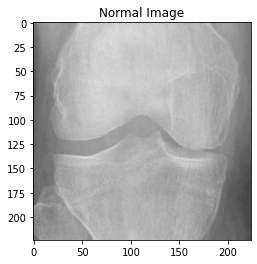

In [12]:
import cv2
img_Normal=cv2.imread('/content/Osteoarthritis_Assignment_dataset/train/Normal/9099440R.png', 1)
plt.imshow(img_Normal)
plt.title('Normal Image')
plt.show()  

# Displaying Osteoarthritis image

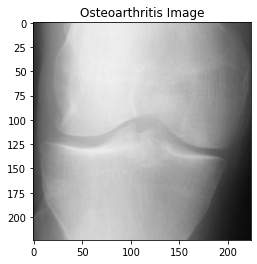

In [13]:
img_Osteo=cv2.imread('/content/Osteoarthritis_Assignment_dataset/train/Osteoarthritis/9000099R.png', 1)
plt.imshow(img_Osteo)
plt.title('Osteoarthritis Image')
plt.show() 

# Preprocessing Images

In [14]:
def preprocessingImages1(path): 
  """
  input : Path 
  output Pre processed images 
  """ 
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function= preprocess_input, horizontal_flip= True) 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [15]:
def preprocessingImages2(path): 
  """
  input : Path 
  output Pre processed images 
  """ 
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input) 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [16]:
path = "/content/Osteoarthritis_Assignment_dataset/train"
train_data = preprocessingImages1(path)

Found 2350 images belonging to 2 classes.


In [17]:
train_data.class_indices

{'Normal': 0, 'Osteoarthritis': 1}

In [18]:
path = "/content/Osteoarthritis_Assignment_dataset/test"
test_data = preprocessingImages2(path)

Found 845 images belonging to 2 classes.


In [19]:
path = "/content/Osteoarthritis_Assignment_dataset/Valid"
val_data = preprocessingImages2(path)

Found 641 images belonging to 2 classes.


# Training MobileNet pretrained model

In [20]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [21]:
for layer in base_model.layers:
  layer.trainable=False

In [22]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

model = Model(base_model.input, X)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

# Compiling Model

In [24]:
model.compile(optimizer='rmsprop', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

In [25]:
# Early stopping and model check point 
from keras.callbacks import ModelCheckpoint, EarlyStopping 

# early stopping 
es = EarlyStopping(monitor="val_accuracy", min_delta= 0.05, patience= 5, verbose= 1) 

# model check point 
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose= 1, save_best_only= True)

cd = [mc,es]

# Fitting Model

In [26]:
hist = model.fit_generator(train_data,
                    steps_per_epoch=10,
                    epochs= 50,
                    validation_data= val_data,
                    validation_steps=10,
                    callbacks= cd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 8.4243 - accuracy: 0.6031
Epoch 1: val_accuracy improved from -inf to 0.68125, saving model to ./bestmodel.h5
10/10 [==============================] - 18s 506ms/step - loss: 8.4243 - accuracy: 0.6031 - val_loss: 3.3618 - val_accuracy: 0.6812
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 3.1418 - accuracy: 0.6625
Epoch 2: val_accuracy improved from 0.68125 to 0.78750, saving model to ./bestmodel.h5
10/10 [==============================] - 5s 480ms/step - loss: 3.1418 - accuracy: 0.6625 - val_loss: 1.4636 - val_accuracy: 0.7875
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 2.6153 - accuracy: 0.7344
Epoch 3: val_accuracy improved from 0.78750 to 0.95000, saving model to ./bestmodel.h5
10/10 [==============================] - 5s 478ms/step - loss: 2.6153 - accuracy: 0.7344 - val_loss: 0.2446 - val_accuracy: 0.9500
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss

In [27]:
model = load_model('/content/bestmodel.h5')

# Model Evaluation

In [29]:
acc = model.evaluate_generator(test_data)[1] 
print(f"Our model accuracy is {acc*100} % ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Our model accuracy is 92.82371401786804 % 


In [30]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

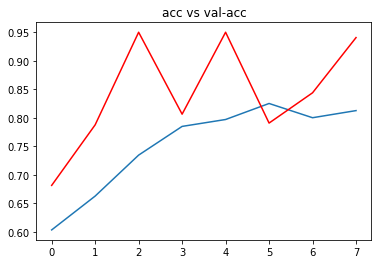

In [31]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title("acc vs val-acc") 
plt.show()

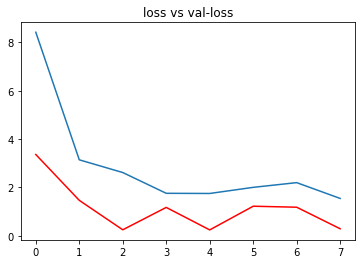

In [32]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title("loss vs val-loss") 
plt.show()

# Predicting Random Normal Image

The image does not have osteoarthritis


<function matplotlib.pyplot.show>

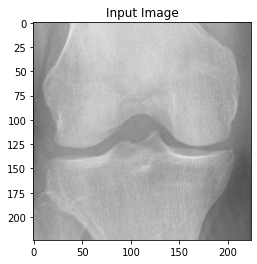

In [33]:
path = '/content/Osteoarthritis_Assignment_dataset/test/Normal/9012435R.png'
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 
pred = np.argmax(model.predict(input_arr))

if pred == 0: 
  print("The image does not have osteoarthritis") 
else: 
  print("The image have osteoarthritis")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show

The image does not have osteoarthritis


<function matplotlib.pyplot.show>

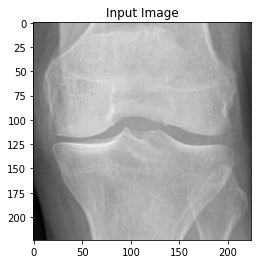

In [34]:
path = '/content/Osteoarthritis_Assignment_dataset/test/Normal/9055429L.png'
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 
pred = np.argmax(model.predict(input_arr))

if pred == 0: 
  print("The image does not have osteoarthritis") 
else: 
  print("The image have osteoarthritis")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show

# Predicting Random Osteoarthritis Image

The image have osteoarthritis


<function matplotlib.pyplot.show>

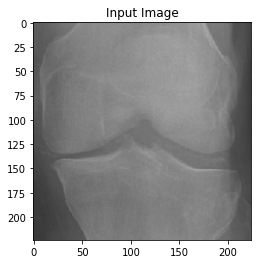

In [36]:
path = '/content/Osteoarthritis_Assignment_dataset/test/Osteoarthritis/9162394_2.png'
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 
pred = np.argmax(model.predict(input_arr))

if pred == 0: 
  print("The image does not have osteoarthritis") 
else: 
  print("The image have osteoarthritis")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show

The image have osteoarthritis


<function matplotlib.pyplot.show>

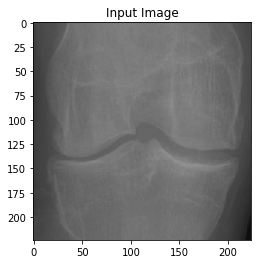

In [38]:
path = '/content/Osteoarthritis_Assignment_dataset/test/Osteoarthritis/9397988_1.png'
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 
pred = np.argmax(model.predict(input_arr))

if pred == 0: 
  print("The image does not have osteoarthritis") 
else: 
  print("The image have osteoarthritis")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show

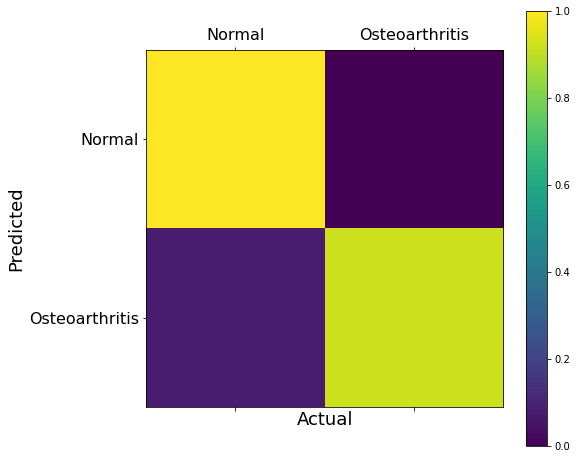

In [43]:
# Confusion Matrix

def show_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(range(2), ['Normal','Osteoarthritis'], fontsize=16)
    plt.yticks(range(2), ['Normal','Osteoarthritis'], fontsize=16)
    plt.colorbar(ctx)
    plt.ylabel("Predicted", fontsize=18)
    plt.xlabel("Actual", fontsize=18)
    plt.show()

true=[]
# I included every image of test in one folder therefore its my custom folder with some name change 
for i in os.listdir('/content/Osteoarthritis_Assignment_dataset/test'):
    X=image.img_to_array(img)
    X=np.expand_dims(X,axis=0)
    val=model.predict(X)
    pred.append(val) 
    if i=='class 0':
      true.append(0)
    else:
      true.append(1) 

show_confusion_matrix(true, pred)